In [18]:
import pandas as pd
from pathlib import Path
from os import listdir
import os.path
from collections import defaultdict
import re
import numpy as np
pd.set_option('display.float_format', lambda x: '%.5f' % x)
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

mpl.style.use('seaborn')
sns.set(font_scale=2.3) 
sns.set_style("white")
mpl.rcParams["font.family"] = "Times New Roman"    


In [19]:
repo_dir = Path("/home/luk/repos/RAPid-Learn/data")
experiment_id = "5bcc1f9ee3394fd49c784d356b806992-2021-10-05_16:52:30-PPO-10000episodes-rewardshapingon"


In [20]:
novelties = ["axetobreakhard", "scrapeplank", "axefirecteasy", "firecraftingtablehard"]
PRENOVELTY_TRANSFER_TRIAL_IDS = {"5bcc1f9ee3394fd49c784d356b806992-2021-10-05_16:52:30-PPO-10000episodes-rewardshapingon": 1,
                                "ce84fd25cf54415bb3885a37d63e37a1-2021-10-05_10:20:18-policy_gradient-10000episodes-rewardshapingon": 2}

In [21]:
def extract_number(f):
    s = re.findall("\d+", f)
    return int(s[0]) if s else -1

In [22]:
csvs_per_novelty = defaultdict(list)
for experiment_id in PRENOVELTY_TRANSFER_TRIAL_IDS.keys():
    experiment_path = repo_dir / experiment_id    
    for novelty in novelties:
        for trial_dir in listdir(experiment_path / novelty):
            if os.path.isdir(experiment_path / novelty / trial_dir):
                for filename in os.listdir(experiment_path / novelty / trial_dir):
                    if filename.endswith(".csv"):
                        csvs_per_novelty[novelty].append(experiment_path / novelty / trial_dir / filename)       

In [23]:
csvs_per_novelty

defaultdict(list,
            {'axetobreakhard': [PosixPath('/home/luk/repos/RAPid-Learn/data/5bcc1f9ee3394fd49c784d356b806992-2021-10-05_16:52:30-PPO-10000episodes-rewardshapingon/axetobreakhard/trial-4/axetobreakhard-4-monitor.csv'),
              PosixPath('/home/luk/repos/RAPid-Learn/data/5bcc1f9ee3394fd49c784d356b806992-2021-10-05_16:52:30-PPO-10000episodes-rewardshapingon/axetobreakhard/trial-1/axetobreakhard-1-monitor.csv'),
              PosixPath('/home/luk/repos/RAPid-Learn/data/5bcc1f9ee3394fd49c784d356b806992-2021-10-05_16:52:30-PPO-10000episodes-rewardshapingon/axetobreakhard/trial-2/axetobreakhard-2-monitor.csv'),
              PosixPath('/home/luk/repos/RAPid-Learn/data/5bcc1f9ee3394fd49c784d356b806992-2021-10-05_16:52:30-PPO-10000episodes-rewardshapingon/axetobreakhard/trial-6/axetobreakhard-6-monitor.csv'),
              PosixPath('/home/luk/repos/RAPid-Learn/data/5bcc1f9ee3394fd49c784d356b806992-2021-10-05_16:52:30-PPO-10000episodes-rewardshapingon/axetobreakhard/tria

In [24]:
dfs = []
for novelty in novelties:
    for csv_path in csvs_per_novelty[novelty]:
            
        trial_id = extract_number(str(os.path.basename(os.path.normpath(csv_path))))
        print(f"novelty: {novelty}, trialid: {trial_id}")
        df = pd.read_csv(csv_path, skiprows=[0])
        if "policy_gradient" in str(csv_path):
            df["experiment"] = "policy_gradient"
        else:
            df["experiment"] = "PPO"

        df["trial"] = trial_id
        df["novelty"] = novelty
        
        df["ts_trained"] = df["l"].loc[df['mode'] == "learn"].cumsum()
        df["ts_trained"].ffill(inplace=True)
        
        during_learning_eval_rows = df.loc[(df['episode_counter'] != df['episode_counter'].max()) & (df['mode'] == "eval")]
        # Any trial that ran fewer than the max number of episodes converged
        during_learning_eval_rows["converged"] = during_learning_eval_rows["episode_counter"].max() <= 9998
        
        print(during_learning_eval_rows)
        dfs.append(during_learning_eval_rows)
        df = df.loc[df["mode"] == "eval"]
        print(df)
        
results_df = pd.concat(dfs).reset_index(drop=True)

novelty: axetobreakhard, trialid: 4
        r    l         t  success  mode  episode_counter experiment  trial  \
101  1651  149  51.33943     True  eval              102        PPO      4   
102  1636  164  51.54692     True  eval              102        PPO      4   
103  1589  211  51.79391     True  eval              102        PPO      4   
104  -150  500  52.41739    False  eval              102        PPO      4   
105  1701   99  52.54127     True  eval              102        PPO      4   
106  1635  115  52.68014     True  eval              102        PPO      4   
107  1568  132  52.84311     True  eval              102        PPO      4   
108  -100  500  53.42833    False  eval              102        PPO      4   
109  1637  163  53.63949     True  eval              102        PPO      4   
110   300  500  54.27735    False  eval              102        PPO      4   
212  1665  135  90.05056     True  eval              203        PPO      4   
213  1525  225  90.34537    

/tmp/ipykernel_2473510/231570313.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  during_learning_eval_rows["converged"] = during_learning_eval_rows["episode_counter"].max() <= 9998
/tmp/ipykernel_2473510/231570313.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  during_learning_eval_rows["converged"] = during_learning_eval_rows["episode_counter"].max() <= 9998
/tmp/ipykernel_2473510/231570313.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usin

         r    l         t  success  mode  episode_counter       experiment  \
100   1505  295  35.71716     True  eval              100  policy_gradient   
101   1310  490  36.08112     True  eval              100  policy_gradient   
102    350  500  36.46979    False  eval              100  policy_gradient   
103   1277  473  36.85356     True  eval              100  policy_gradient   
104   1472  328  37.12553     True  eval              100  policy_gradient   
...    ...  ...       ...      ...   ...              ...              ...   
1755  1599  201 387.87387     True  eval             1600  policy_gradient   
1756  1555  145 388.00165     True  eval             1600  policy_gradient   
1757  1488  262 388.24934     True  eval             1600  policy_gradient   
1758  1531  119 388.34910     True  eval             1600  policy_gradient   
1759  1476  274 388.58824     True  eval             1600  policy_gradient   

      trial         novelty   ts_trained  converged  
100      

/tmp/ipykernel_2473510/231570313.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  during_learning_eval_rows["converged"] = during_learning_eval_rows["episode_counter"].max() <= 9998
/tmp/ipykernel_2473510/231570313.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  during_learning_eval_rows["converged"] = during_learning_eval_rows["episode_counter"].max() <= 9998
/tmp/ipykernel_2473510/231570313.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usin

        r    l        t  success  mode  episode_counter experiment  trial  \
101  1460   40 47.56006     True  eval              102        PPO      3   
102  1272  228 47.81173     True  eval              102        PPO      3   
103  1325  175 48.01770     True  eval              102        PPO      3   
104  1307  193 48.24017     True  eval              102        PPO      3   
105  1358  142 48.40333     True  eval              102        PPO      3   
..    ...  ...      ...      ...   ...              ...        ...    ...   
340  1443   57 95.47853     True  eval              226        PPO      3   
341  1402   98 95.60153     True  eval              226        PPO      3   
342  1432   68 95.68915     True  eval              226        PPO      3   
343  1439   61 95.76426     True  eval              226        PPO      3   
344  1425   75 95.86163     True  eval              226        PPO      3   

         novelty  ts_trained  
101  scrapeplank 28913.00000  
102  scrapepl

/tmp/ipykernel_2473510/231570313.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  during_learning_eval_rows["converged"] = during_learning_eval_rows["episode_counter"].max() <= 9998
/tmp/ipykernel_2473510/231570313.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  during_learning_eval_rows["converged"] = during_learning_eval_rows["episode_counter"].max() <= 9998
/tmp/ipykernel_2473510/231570313.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usin

        r    l         t  success  mode  episode_counter experiment  trial  \
101  1312  488  96.27035     True  eval              102        PPO      1   
102  1526  224  96.62654     True  eval              102        PPO      1   
103  1642  258  97.01317     True  eval              102        PPO      1   
104  1625  125  97.21443     True  eval              102        PPO      1   
105  -300  500  98.05614    False  eval              102        PPO      1   
..    ...  ...       ...      ...   ...              ...        ...    ...   
772  1690  110 441.37217     True  eval              708        PPO      1   
773  1460  140 441.61211     True  eval              708        PPO      1   
774  1701   99 441.77756     True  eval              708        PPO      1   
775  1652   98 441.94034     True  eval              708        PPO      1   
776  1710   90 442.09521     True  eval              708        PPO      1   

           novelty   ts_trained  converged  
101  axefirecteasy

/tmp/ipykernel_2473510/231570313.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  during_learning_eval_rows["converged"] = during_learning_eval_rows["episode_counter"].max() <= 9998
/tmp/ipykernel_2473510/231570313.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  during_learning_eval_rows["converged"] = during_learning_eval_rows["episode_counter"].max() <= 9998
/tmp/ipykernel_2473510/231570313.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usin

         r    l          t  success  mode  episode_counter       experiment  \
100   -500  500   47.70792    False  eval              100  policy_gradient   
101   1238  462   48.15732     True  eval              100  policy_gradient   
102   1400  500   48.59308     True  eval              100  policy_gradient   
103   -100  500   49.12067    False  eval              100  policy_gradient   
104   -300  500   49.51873    False  eval              100  policy_gradient   
...    ...  ...        ...      ...   ...              ...              ...   
3955  1650  150 1266.63897     True  eval             3600  policy_gradient   
3956  1467  233 1266.88176     True  eval             3600  policy_gradient   
3957  1572  228 1267.13922     True  eval             3600  policy_gradient   
3958  1673  127 1267.27682     True  eval             3600  policy_gradient   
3959  1515  185 1267.49251     True  eval             3600  policy_gradient   

      trial        novelty    ts_trained  converged

/tmp/ipykernel_2473510/231570313.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  during_learning_eval_rows["converged"] = during_learning_eval_rows["episode_counter"].max() <= 9998
/tmp/ipykernel_2473510/231570313.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  during_learning_eval_rows["converged"] = during_learning_eval_rows["episode_counter"].max() <= 9998
/tmp/ipykernel_2473510/231570313.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usin

        r    l         t  success  mode  episode_counter experiment  trial  \
101  1655  145  81.49862     True  eval              102        PPO      7   
102  1623  177  81.78573     True  eval              102        PPO      7   
103  1644  156  82.03422     True  eval              102        PPO      7   
104     0  500  82.90044    False  eval              102        PPO      7   
105  1671  129  83.12971     True  eval              102        PPO      7   
106  1544  356  83.71107     True  eval              102        PPO      7   
107  1543  157  83.98048     True  eval              102        PPO      7   
108  1336  464  84.75253     True  eval              102        PPO      7   
109   300  500  85.59359    False  eval              102        PPO      7   
110  1679  121  85.79511     True  eval              102        PPO      7   
212  1437  263 135.52295     True  eval              203        PPO      7   
213  1494  206 135.86872     True  eval              203        

/tmp/ipykernel_2473510/231570313.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  during_learning_eval_rows["converged"] = during_learning_eval_rows["episode_counter"].max() <= 9998
/tmp/ipykernel_2473510/231570313.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  during_learning_eval_rows["converged"] = during_learning_eval_rows["episode_counter"].max() <= 9998
/tmp/ipykernel_2473510/231570313.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usin

In [25]:
dfs

[        r    l         t  success  mode  episode_counter experiment  trial  \
 101  1651  149  51.33943     True  eval              102        PPO      4   
 102  1636  164  51.54692     True  eval              102        PPO      4   
 103  1589  211  51.79391     True  eval              102        PPO      4   
 104  -150  500  52.41739    False  eval              102        PPO      4   
 105  1701   99  52.54127     True  eval              102        PPO      4   
 106  1635  115  52.68014     True  eval              102        PPO      4   
 107  1568  132  52.84311     True  eval              102        PPO      4   
 108  -100  500  53.42833    False  eval              102        PPO      4   
 109  1637  163  53.63949     True  eval              102        PPO      4   
 110   300  500  54.27735    False  eval              102        PPO      4   
 212  1665  135  90.05056     True  eval              203        PPO      4   
 213  1525  225  90.34537     True  eval            

In [31]:
per_trial_episode_df = results_df.groupby(by=["experiment", "novelty", "trial", "episode_counter"]).agg({'success': ['mean'], "ts_trained": "mean"}).reset_index()
per_trial_episode_df.columns = [' '.join(col).strip() for col in per_trial_episode_df.columns.values]
per_trial_episode_df

,experiment,novelty,trial,episode_counter,success mean,ts_trained mean
0,PPO,axefirecteasy,1,102,0.80000,44424.00000
1,PPO,axefirecteasy,1,203,0.60000,75208.00000
2,PPO,axefirecteasy,1,304,0.60000,103925.00000
3,PPO,axefirecteasy,1,405,0.90000,127832.00000
4,PPO,axefirecteasy,1,506,1.00000,148750.00000
...,...,...,...,...,...,...
1157,policy_gradient,scrapeplank,10,1200,0.90000,204589.00000
1158,policy_gradient,scrapeplank,10,1300,0.70000,217698.00000
1159,policy_gradient,scrapeplank,10,1400,1.00000,233428.00000
1160,policy_gradient,scrapeplank,10,1500,1.00000,247703.00000


In [32]:
graph_df = per_trial_episode_df.groupby(by=["experiment", "novelty", "episode_counter"]).agg({'success mean': ['mean', 'std'], "ts_trained mean": "mean"}).reset_index()
graph_df.fillna(0, inplace=True)
graph_df.columns = [' '.join(col).strip() for col in graph_df.columns.values]
graph_df["lower_std"] = (graph_df["success mean mean"] - graph_df["success mean std"]).clip(lower=0)
graph_df["upper_std"] = (graph_df["success mean mean"] + graph_df["success mean std"]).clip(upper=1)

graph_df

,experiment,novelty,episode_counter,success mean mean,success mean std,ts_trained mean mean,lower_std,upper_std
0,PPO,axefirecteasy,102,0.68000,0.12293,41136.60000,0.55707,0.80293
1,PPO,axefirecteasy,203,0.79000,0.11972,70559.30000,0.67028,0.90972
2,PPO,axefirecteasy,304,0.86000,0.14298,95632.10000,0.71702,1.00000
3,PPO,axefirecteasy,405,0.85000,0.09258,119436.37500,0.75742,0.94258
4,PPO,axefirecteasy,506,0.91250,0.11260,139867.62500,0.79990,1.00000
...,...,...,...,...,...,...,...,...
220,policy_gradient,scrapeplank,2000,0.90000,0.00000,341319.00000,0.90000,0.90000
221,policy_gradient,scrapeplank,2100,0.90000,0.00000,354253.00000,0.90000,0.90000
222,policy_gradient,scrapeplank,2200,0.90000,0.00000,368274.00000,0.90000,0.90000
223,policy_gradient,scrapeplank,2300,0.90000,0.00000,380698.00000,0.90000,0.90000


In [33]:
graph_df.loc[(graph_df["novelty"] == "axefirecteasy") & (graph_df["experiment"] == "policy_gradient")]

,experiment,novelty,episode_counter,success mean mean,success mean std,ts_trained mean mean,lower_std,upper_std
46,policy_gradient,axefirecteasy,100,0.09000,0.11972,48007.70000,0.00000,0.20972
47,policy_gradient,axefirecteasy,200,0.16000,0.09661,95187.40000,0.06339,0.25661
48,policy_gradient,axefirecteasy,300,0.26000,0.16465,140377.10000,0.09535,0.42465
49,policy_gradient,axefirecteasy,400,0.34000,0.23664,183819.10000,0.10336,0.57664
50,policy_gradient,axefirecteasy,500,0.45000,0.25927,224682.20000,0.19073,0.70927
51,policy_gradient,axefirecteasy,600,0.50000,0.28284,263195.80000,0.21716,0.78284
52,policy_gradient,axefirecteasy,700,0.63000,0.23118,299528.50000,0.39882,0.86118
53,policy_gradient,axefirecteasy,800,0.64000,0.20111,332762.00000,0.43889,0.84111
54,policy_gradient,axefirecteasy,900,0.76000,0.20656,364845.50000,0.55344,0.96656
55,policy_gradient,axefirecteasy,1000,0.75000,0.21731,395459.20000,0.53269,0.96731


In [34]:
def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

/home/luk/programs/miniconda3/envs/rapid-learn/lib/python3.9/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
/home/luk/programs/miniconda3/envs/rapid-learn/lib/python3.9/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
/home/luk/programs/miniconda3/envs/rapid-learn/lib/python3.9/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org

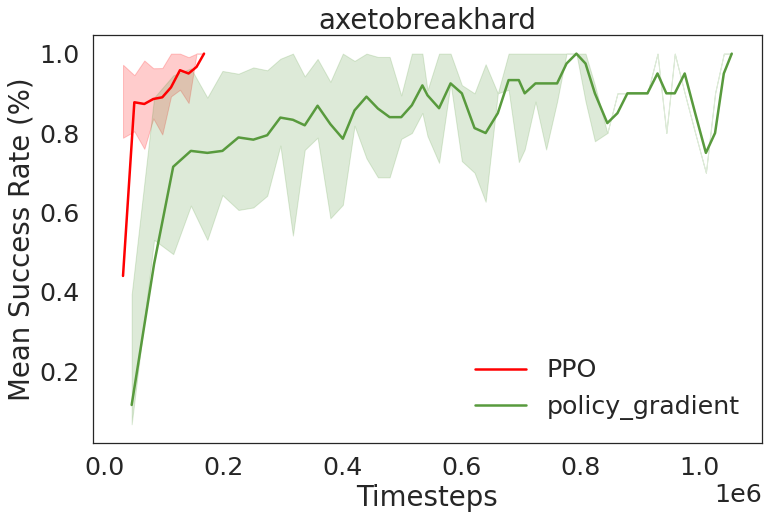

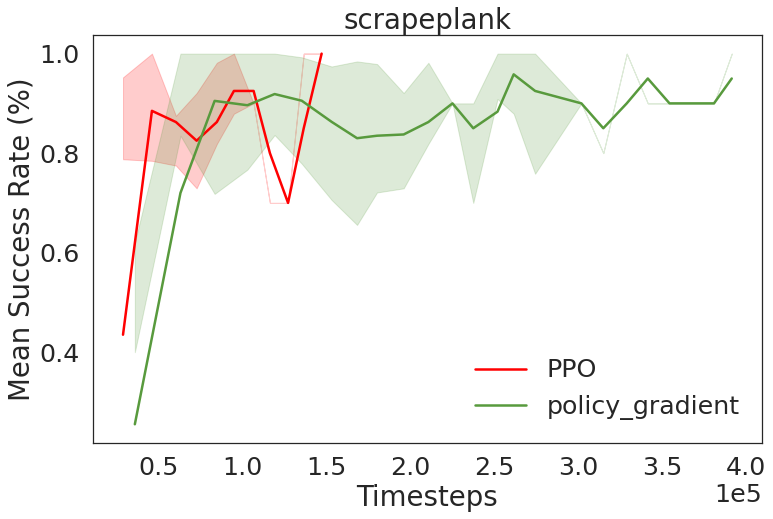

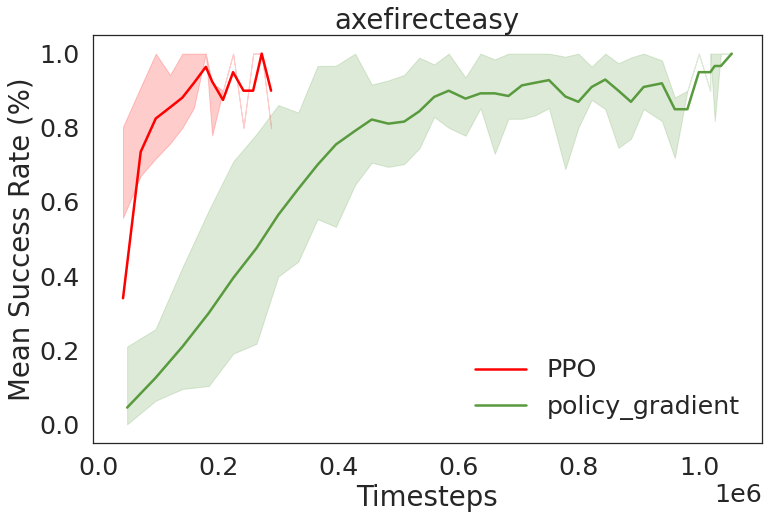

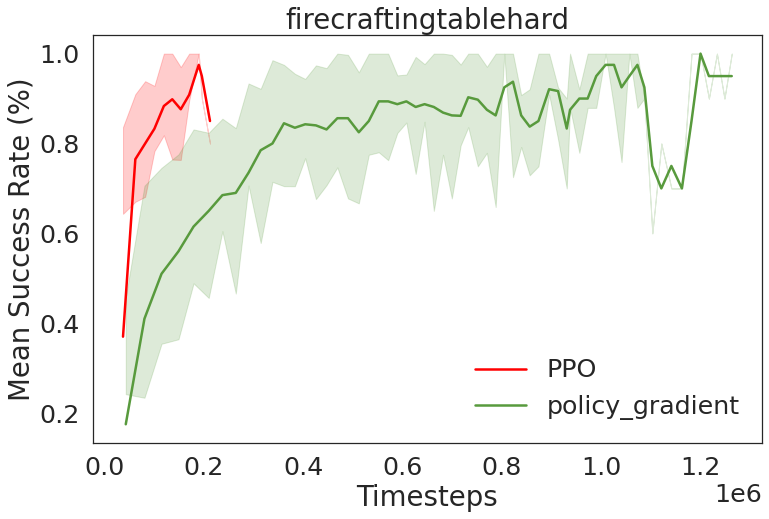

In [45]:
for novelty in novelties:
    novelty_graph_df = graph_df.loc[graph_df["novelty"] == novelty]
    fig, ax = plt.subplots(figsize=(12,7.5))
    plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    for name, color in {'PPO': '#ff0001', 'policy_gradient': '#589A3D'}.items():
        sub_df = novelty_graph_df[novelty_graph_df.experiment == name]
        sub_df.sort_values(by="ts_trained mean mean", inplace=True)
        ax.plot(sub_df["ts_trained mean mean"], smooth(sub_df["success mean mean"], 2), label=name, linestyle = 'solid', linewidth = 2.5,antialiased=True, color=color)
        ax.fill_between(sub_df["ts_trained mean mean"], sub_df["lower_std"], sub_df["upper_std"], alpha=0.2, antialiased=True, color=color)
        ax.set_title(novelty)
        ax.set_xlabel("Timesteps")
        ax.set_ylabel("Mean Success Rate (%)")   
        ax.legend()
        plt.savefig(f'{repo_dir}/plots/baselines_{novelty}.png')

In [44]:
graph_df.loc[graph_df["novelty"] == "axefirecteasy"]

,experiment,novelty,episode_counter,success mean mean,success mean std,ts_trained mean mean,lower_std,upper_std
0,PPO,axefirecteasy,102,0.68000,0.12293,41136.60000,0.55707,0.80293
1,PPO,axefirecteasy,203,0.79000,0.11972,70559.30000,0.67028,0.90972
2,PPO,axefirecteasy,304,0.86000,0.14298,95632.10000,0.71702,1.00000
3,PPO,axefirecteasy,405,0.85000,0.09258,119436.37500,0.75742,0.94258
4,PPO,axefirecteasy,506,0.91250,0.11260,139867.62500,0.79990,1.00000
5,PPO,axefirecteasy,607,0.92857,0.07559,158959.28571,0.85298,1.00000
6,PPO,axefirecteasy,708,1.00000,0.00000,178939.80000,1.00000,1.00000
7,PPO,axefirecteasy,809,0.85000,0.07071,189446.50000,0.77929,0.92071
8,PPO,axefirecteasy,910,0.90000,0.00000,207484.00000,0.90000,0.90000
9,PPO,axefirecteasy,1011,1.00000,0.00000,224298.00000,1.00000,1.00000
